In [1]:
!pip install transitleastsquares
from astropy.io import fits
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

import numpy as np

url = 'https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00159951311-s03_tess_v1_lc.fits'
hdu = fits.open(url)
time = hdu[1].data['TIME']
flux = hdu[1].data['PDCSAP_FLUX']  # values with non-zero quality are nan or zero'ed
time, flux = cleaned_array(time, flux)  # remove invalid values such as nan, inf, non, negative
flux = flux / np.median(flux)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 1.2 MB/s 
     |████████████████████████████████| 4.5 MB 7.1 MB/s 
     |████████████████████████████████| 394 kB 39.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 832 kB 17.4 MB/s 
     |████████████████████████████████| 48 kB 2.9 MB/s 
     |████████████████████████████████| 4.0 MB 38.8 MB/s 
  Created wheel for batman-package: filename=batman_package-2.4.9-cp37-cp37m-linux_x86_64.whl size=221090 sha256=aafc32421e6e6768a962421bd82c0a1ad6dada57e571c244317f82e4e7ec4757
  Stored in directory: /root/.cache/pip/wheels/90/76/e2/1e2923a7fe1c1ee8d6f5ae53e8f1bc75e070f5f174bf02badc
Successfully built batman-package


In [32]:
def run_bls(time, flux, 
            bls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}, 
            compute_stats: bool = True): 

    '''
    args: 
        stitched_lc: list of stitched light curve arrays [time, flux]
        bls_params: params for bls execution. see documentation
        compute_stats: compute statistics on best period/duration combination? default False
    returns: 
        best_params: [index, period, t0, duration, sig_diff] for highest power period (sig_diff is sig_diff between left/right depths)
        results: the BLS results array 
        bls_model: the BLS model  
        in_transit_mask: mask for the in_transit points. to get not in transit, do ~in_transit_mask
        stats: if compute_stats==True, then the stats on the best period/duration/t0 are returned
    '''

    from astropy.timeseries import BoxLeastSquares
    import numpy as np

    durations = np.array(bls_params['durations'])
    bls_model = BoxLeastSquares(t=time, y=flux)
    #bls_model.flatten()
    results = bls_model.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                            minimum_period=bls_params['min_per'], 
                            maximum_period=bls_params['max_per'],
                            objective=bls_params['objective'])

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    in_transit = bls_model.transit_mask(time, period, 2*duration, t0)

    best_params = [index, period, t0, duration]

    if compute_stats: 
        stats = bls_model.compute_stats(period, duration, t0)

        depth_odd = stats['depth_odd']
        err_odd = depth_odd[1]
        depth_odd = depth_odd[0]
        depth_even = stats['depth_even']
        err_even = depth_even[1]
        depth_even = depth_even[0]

        diff = np.abs(depth_odd-depth_even)
        unc_diff = ((err_even/depth_even)**2+(err_odd/depth_odd)**2)**0.5
        sig_diff = diff/unc_diff 

        best_params.append(sig_diff)

        return best_params, results, bls_model, in_transit, stats

    else: 
        return best_params, results, bls_model, in_transit 

In [72]:
def rebin_lightcurve(folded_x, folded_flux, factor:int=30): 
        '''
        Arguments: 
            folded_x: folded time values
            folded_flux: corresponding flux values
        Returns: 
            binned_x: re-binned folded time values
            binned_flux: re-binned flux
        '''

        binned_x, binned_flux = ([], [])
        step = int(len(folded_x)/factor)
        indices = list(range(0, len(folded_x), step))
        for index, i in enumerate(indices): 
            if index==len(indices)-1: 
                binned_x.append(np.mean(folded_x[i:]))
                binned_flux.append(np.mean(folded_flux[i:]))
            else: 
                binned_x.append(np.mean(folded_x[i:indices[index+1]]))
                binned_flux.append(np.mean(folded_flux[i:indices[index+1]]))

        return binned_x, binned_flux 

def phase(time, flux, best_params, bls_model, fraction:int=0.2): 
        '''
        Arguments: 
            time: array of time values
            flux: corresponding array of flux values
            period: period to fold to 
            t0: t0 from BLS/TLS 
            bls_model: bls model (FIX FOR TLS!)
            fraction: how far from median time to go; default is 0.2
        Returns: 
            folded time values, folded flux values, x and f (latter two for red bls model)
        '''
        period = best_params[1]
        t0 = best_params[2]
        duration = best_params[3]
        x = (time - t0 + 0.5*period) % period - 0.5*period
        m = np.abs(x) < 0.2
        f = bls_model.model(x + t0, period, duration, t0)

        return x[m], flux[m], x, f

In [90]:
def bls_validation_mosaic(tic_id:str, clean_time:np.array, detrend_flux:np.array, 
                          raw_time:np.array, raw_flux:np.array, 
                          best_params:list, bls_results, bls_model, in_transit, bls_stats, 
                          path:str=None, dpi:int=150): 

    '''
    arguments: 
        tic_id: tic id 
        clean_time: detrended and flare removed time array
        detrend_flux: flux values corresponding to clean_time arg
        raw_time: array of "raw" time values, i.e. not detrended and potentially with flares
        raw_flux: flux array corresponding to raw_time arg
        best_params, bls_results, bls_model, in_transit, bls_stats: the items returned by the run_bls function in pipeline_functions.py (NOTE: in run_bls, stats must be set to be calculated!)
        path: if defined, plot will be saved as the provided path. Otherwise, it will be displayed
        dpi: dpi of saved plot

    returns: 
    '''

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    #from sunnyhills.borrowed import intransit_stats 

    plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')
    fig = plt.figure(constrained_layout=True, figsize=(12,12))

    gs = GridSpec(4, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :-1])
    ax4 = fig.add_subplot(gs[-1, 0])
    ax5 = fig.add_subplot(gs[-1, -2])
    ax6 = fig.add_subplot(gs[2:, -1])

    # raw and trend light curve
    ax1.scatter(raw_time, raw_flux, s=1)
    ax1.set(ylabel='Flux')

    # detrend light curve
    ax2.scatter(clean_time, detrend_flux, s=1)
    index = np.argmax(bls_results.power)
    period = bls_results.period[index]
    t0 = bls_results.transit_time[index]
    duration = bls_results.duration[index]

    phased_time, phased_flux, x, f = phase(clean_time, detrend_flux, best_params, bls_model)

    ax2.vlines(clean_time[in_transit], min(detrend_flux), max(detrend_flux), color='red', lw=0.05,alpha=0.4, zorder=0)
    ax2.set(ylabel='Detrended Flux')

    for ax in [ax1, ax2]: 
        ax.set(xlabel='Time (days)')

    # phase folded
    ax3.scatter(phased_time, phased_flux, s=3, c='grey')

    binned_x, binned_flux = rebin_lightcurve(phased_time, phased_flux)
    
    ax3.plot(x, f, color='red', alpha=0.5)
    ax3.scatter(binned_x, binned_flux, c='orange', s=40, edgecolor='black')

    ax3.set(xlim=(-0.2, 0.2))

    for ax in [ax3, ax4, ax5]: 
        ax.set(xlabel='Time from mid-transit (days)', ylabel='Detrended Flux')

    # transit depths (odd, even)

    # https://github.com/hippke/tls/blob/71da590d3e199264822db425ab9f9f633253986e/transitleastsquares/stats.py#L338

    sig_diff = best_params[4]

    intransit_stats = tls_intransit_stats(clean_time, detrend_flux, 
                                          bls_stats['transit_times'], 
                                          best_params[3])

    odd_ = intransit_stats[4]
    odd_time, odd_flux = (odd_[0], odd_[1])
    odd_phased_time, odd_phased_flux, odd_x, odd_f = phase(odd_time, odd_flux, best_params, bls_model)
    odd_binned_time, odd_binned_flux = rebin_lightcurve(odd_phased_time, odd_phased_flux, factor=20)

    even_ = intransit_stats[5]
    even_time, even_flux = (even_[0], even_[1])
    even_phased_time, even_phased_flux, even_x, even_f = phase(even_time, even_flux, best_params, bls_model)
    even_phased_time = even_phased_time + 2.5*np.max(odd_phased_time) # shift over to show together 
    
    odd_even_median = (np.max(odd_phased_time)+np.min(even_phased_time))/2

    even_binned_time, even_binned_flux = rebin_lightcurve(even_phased_time, even_phased_flux, factor=20)

    ax4.scatter(odd_phased_time, odd_phased_flux, s=3, c='grey')
    ax4.scatter(even_phased_time, even_phased_flux, s=3, c='grey')
    ax4.scatter(odd_binned_time, odd_binned_flux, c='orange', s=40, edgecolor='black')
    ax4.scatter(even_binned_time, even_binned_flux, c='orange', s=40, edgecolor='black')

    ax4.axvline(x=odd_even_median, color='black', lw=0.5, label='Diff: '+str(round(sig_diff, 5))+r'$\sigma$')

    ax4.legend(loc='upper right', handlelength=0)

    ax4.set(xlabel='Odd (left) and Even (right) Folded Transits')
    ax4.xaxis.set_major_locator(plt.NullLocator())

    # periodogram 
    ax5.plot(bls_results.period, bls_results.power)
    ax5.set(xlabel='Period (d)', ylabel='Power')

    #ax6.axis('off')
    ax6.tick_params(labelbottom=False, labelleft=False, axis='both', which='both', length=0)

    index = np.argmax(bls_results.power)
    text_info = []
    for key_name in bls_results.keys(): 
        result = bls_results[key_name]
        if type(result)!=str: 
            result = str(round(result[index], 5))

        text_info.append(key_name+': '+result+'\n')

    text_info.append('num transits: '+str(len(transit_times)))


    ax6.text(x=0.1, y=0.5, s='\n'.join(str(i).replace('_','') for i in text_info), fontsize='large', va='center', transform=ax6.transAxes)

    ax1.set_title('TIC: '+str(tic_id).replace('_','')+' PERIOD: '+str(round(period, 5)), size='xx-large')

    if path==None:
        plt.show()
    else: 
        plt.savefig(path, dpi=dpi)

In [58]:
best_params, results, bls_model, in_transit, stats = run_bls(time, flux)

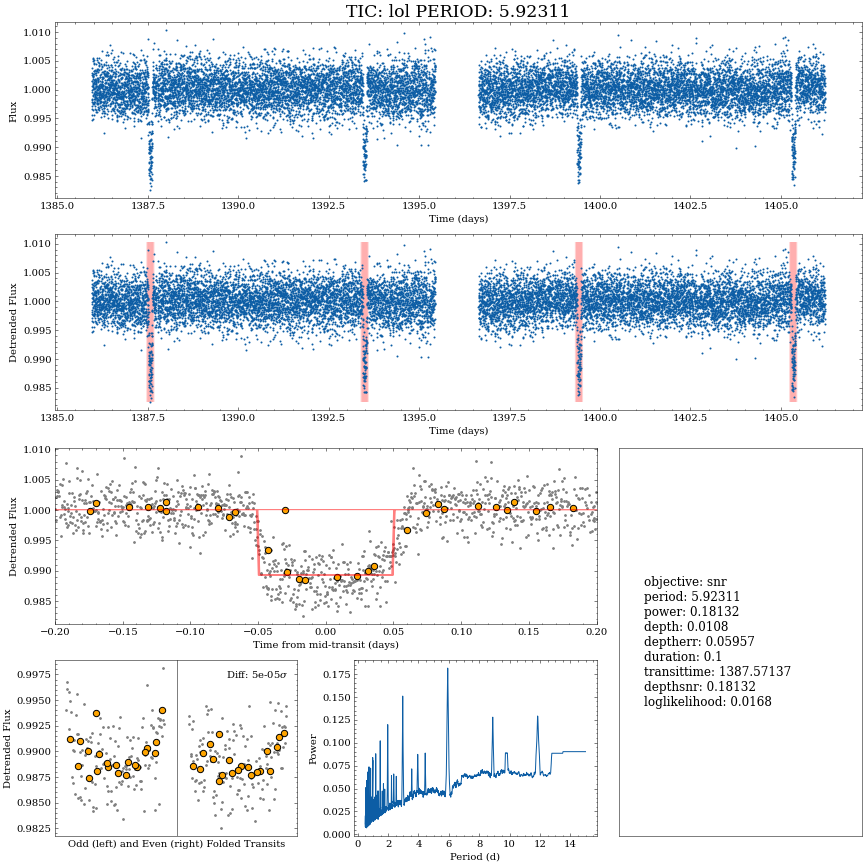

In [91]:
bls_validation_mosaic('lol', time, flux, time, flux, best_params, results, bls_model, in_transit, stats)

In [15]:
transit_times = stats['transit_times']
transit_duration_in_days = best_params[3]
print(transit_duration_in_days)
#transit_times, transit_duration_in_days

0.1


In [36]:
def tls_intransit_stats(t, y, transit_times, transit_duration_in_days):
    """
    Return all intransit odd and even flux points
    
    Source: Hippke's TLS Code
    Status: light modification 
    """

    import numpy as np

    all_flux_intransit_odd = np.array([])
    all_flux_intransit_even = np.array([])
    all_time_intransit_odd = np.array([])
    all_time_intransit_even = np.array([])
    all_flux_intransit = np.array([])
    all_idx_intransit = np.array([])
    per_transit_count = np.zeros([len(transit_times)])
    transit_depths = np.zeros([len(transit_times)])
    transit_depths_uncertainties = np.zeros([len(transit_times)])

    for i in range(len(transit_times)):

        depth_mean_odd = np.nan
        depth_mean_even = np.nan
        depth_mean_odd_std = np.nan
        depth_mean_even_std = np.nan

        mid_transit = transit_times[i]
        tmin = mid_transit - 0.5 * transit_duration_in_days
        tmax = mid_transit + 0.5 * transit_duration_in_days
        if np.isnan(tmin) or np.isnan(tmax):
            idx_intransit = []
            flux_intransit = []
            time_intransit = []
            mean_flux = np.nan
        else:
            idx_intransit = np.where(np.logical_and(t > tmin, t < tmax))
            flux_intransit = y[idx_intransit]
            time_intransit = t[idx_intransit]
            if len(y[idx_intransit]) > 0:
                mean_flux = np.mean(y[idx_intransit])
            else:
                mean_flux = np.nan
        intransit_points = np.size(y[idx_intransit])
        transit_depths[i] = mean_flux
        if len(y[idx_intransit] > 0):
            transit_depths_uncertainties[i] = np.std(y[idx_intransit]) / np.sqrt(
                intransit_points
            )
        else:
            transit_depths_uncertainties[i] = np.nan
        per_transit_count[i] = intransit_points

        # Check if transit odd/even to collect the flux for the mean calculations
        if i % 2 == 0:  # even
            all_flux_intransit_even = np.append(
                all_flux_intransit_even, flux_intransit
            )

            all_time_intransit_even = np.append(
                all_time_intransit_even, time_intransit
            )
        else:  # odd
            all_flux_intransit_odd = np.append(
                all_flux_intransit_odd, flux_intransit
            )
            all_time_intransit_odd = np.append(
                all_time_intransit_odd, time_intransit
            )

        if len(all_flux_intransit_odd) > 0:
            depth_mean_odd = np.mean(all_flux_intransit_odd)

            depth_mean_odd_std = np.std(all_flux_intransit_odd) / np.sum(
                len(all_flux_intransit_odd)
            ) ** (0.5)
        if len(all_flux_intransit_even) > 0:
            depth_mean_even = np.mean(all_flux_intransit_even)
            depth_mean_even_std = np.std(all_flux_intransit_even) / np.sum(
                len(all_flux_intransit_even)
            ) ** (0.5)

    return (
        depth_mean_odd,
        depth_mean_even,
        depth_mean_odd_std,
        depth_mean_even_std,
        (all_time_intransit_odd,all_flux_intransit_odd),
        (all_time_intransit_even, all_flux_intransit_even),
        per_transit_count,
        transit_depths,
        transit_depths_uncertainties,
    )

In [23]:
tls_results = intransit_stats(time, flux, transit_times, transit_duration_in_days)

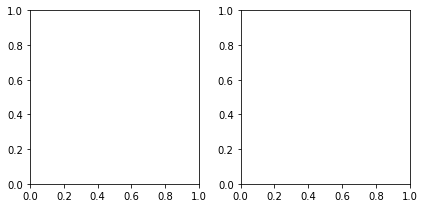

In [18]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1,2, figsize=(6,3))

plt.tight_layout()

